In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/all-aspects/all_aspects_just_aspect.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect.csv
/kaggle/input/all-aspects/all_tagged_aspects_sentences.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_sentences.csv
/kaggle/input/all-aspects/reviews.csv
/kaggle/input/all-aspects/cleaned.csv
/kaggle/input/all-aspects/all_tagged_aspects.csv
/kaggle/input/all-aspects/all_aspects.csv


In [35]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import sys
import time
import tqdm

import numpy as np
import pandas as pd

import pickle

import string
import io
import re
import nltk
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.util import ngrams
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

from IPython.display import Markdown, clear_output

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
df = pd.read_csv("../input/all-aspects/cleaned.csv")

In [7]:
df = df.dropna().reset_index(drop=True)

In [8]:
label_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}
df['aspect_polarity'] = df['sentiment'].map(label_mapping)

In [9]:
df = df[["text", "aspect_polarity"]]

In [ ]:
def preprocess(t):
    text = t.replace(r'http\S+', '')
    text = text.replace(r'www\S+', '')
    text = re.sub('a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)
    text = re.sub('<.*?>', '', text)
    text = re.sub('[0-9]+', '', text)
    text = text.translate(text.maketrans('', '', string.punctuation))
    text = text.replace('"', '').replace("’", '').replace("'", '').replace("”", '')
    text = emoji.replace_emoji(text)
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

In [ ]:
df["cleaned"] = df["review"].progress_apply(preprocess)

In [ ]:
freq = pd.Series(' '.join(df['cleaned']).split()).value_counts()
less_freq = list(freq[freq == 1].index)

In [ ]:
df['cleaned'] = df['cleaned'].progress_apply(lambda x: " ".join(x for x in x.split() if x not in less_freq))

In [10]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [11]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

In [ ]:
df['text'] = df['aspect'] + " [SEP] " + df['review']

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [49]:
MAX_LEN = 64
BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 2e-5

In [50]:
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-cased", num_labels=3).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [52]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['aspect_polarity'], test_size=0.1, random_state=42)

In [53]:
train_dataset = SentimentDataset(train_texts.to_numpy(), train_labels.to_numpy(), tokenizer, MAX_LEN)
val_dataset = SentimentDataset(val_texts.to_numpy(), val_labels.to_numpy(), tokenizer, MAX_LEN)

In [54]:
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [55]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [58]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm.tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [59]:
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm.tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [60]:
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, scheduler, device)
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, device)
    print(f'Val   loss {val_loss} accuracy {val_acc}')

Epoch 1/4
----------


100%|██████████| 4561/4561 [24:45<00:00,  3.07it/s]


Train loss 0.518720588078561 accuracy 0.8029849314411408


100%|██████████| 507/507 [01:09<00:00,  7.32it/s]


Val   loss 0.4626562777884613 accuracy 0.8275053962380513
Epoch 2/4
----------


100%|██████████| 4561/4561 [24:44<00:00,  3.07it/s]


Train loss 0.3924622581755088 accuracy 0.8559955596061206


100%|██████████| 507/507 [01:09<00:00,  7.33it/s]


Val   loss 0.4007182188434949 accuracy 0.8539623805118718
Epoch 3/4
----------


100%|██████████| 4561/4561 [24:44<00:00,  3.07it/s]


Train loss 0.3008475232125309 accuracy 0.8924780549978415


100%|██████████| 507/507 [01:08<00:00,  7.38it/s]


Val   loss 0.3914110418666279 accuracy 0.8646931853222326
Epoch 4/4
----------


100%|██████████| 4561/4561 [24:42<00:00,  3.08it/s]


Train loss 0.23571169212937512 accuracy 0.9164342540755004


100%|██████████| 507/507 [01:08<00:00,  7.40it/s]

Val   loss 0.3935033754396015 accuracy 0.8701202590194266


In [61]:
y_pred = []
y_true = []

model = model.eval()

with torch.no_grad():
    for d in val_data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

In [62]:
model_precision_score = precision_score(y_true, y_pred, average='macro')
model_f1_score = f1_score(y_true, y_pred, average='macro')
model_recall_score = recall_score(y_true, y_pred, average='macro')
model_accuracy_score = accuracy_score(y_true, y_pred)

print(f"Precision Score = {model_precision_score * 100:.2f}%")
print(f"F1 Score = {model_f1_score * 100:.2f}%")
print(f"Recall Score = {model_recall_score * 100:.2f}%")
print(f"Accuracy Score = {model_accuracy_score * 100:.2f}%")

Precision Score = 86.52%
F1 Score = 86.52%
Recall Score = 87.01%
Accuracy Score = 87.01%


In [63]:
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.88      0.92      0.90      8862
     Neutral       0.67      0.38      0.48       868
    Positive       0.87      0.87      0.87      6485

    accuracy                           0.87     16215
   macro avg       0.81      0.72      0.75     16215
weighted avg       0.87      0.87      0.87     16215



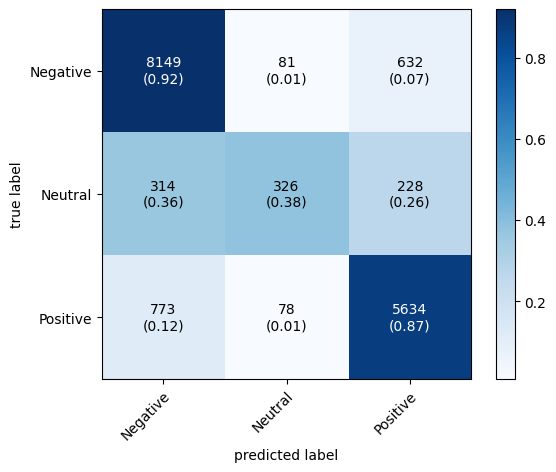

In [64]:
cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["Negative", "Neutral", "Positive"])
plt.show()